In [1]:
# !pip list --format=freeze > requirements.txt

# Librairies

In [2]:
%matplotlib inline
# generic libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

# machine learning
from sklearn.metrics import r2_score

# path and files treatment
import glob
import os

# Variables

In [3]:
# env could be 'local' or 'kaggle'
env = 'local'

if env == 'local':
    data_folder = './data'
elif env == 'kaggle':
    data_folder = '../input/optiver-realized-volatility-prediction'
else:
    print('env var must be defined')

bk_train_fol = '/book_train.parquet/'
td_train_fol = '/trade_train.parquet/'
bk_test_fol = '/book_test.parquet/'
td_test_fol = '/trade_test.parquet/'



# Functions

In [4]:
def add_wap(df, number=1, column_prefix='wap'):
    df[column_prefix + str(number)] = (
        df['bid_price'+ str(number)] * df['ask_size'+ str(number)] + df['ask_price'+ str(number)] * df['bid_size'+ str(number)]) / (
            df['bid_size'+ str(number)]+ df['ask_size'+ str(number)])

In [5]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

# Exploration

## Book train 

In [6]:
# Test tp know if the book and trade data are on same stocks
os.listdir(data_folder + td_train_fol) == os.listdir(data_folder + bk_train_fol)

True

In [7]:
def load_df(df_folder, nb_stock_to_load, data_folder=data_folder):
    '''load a parquet 
    
    arguments
    ---------------
    data_folder (str)
    df_folder (str)
    nb_stock_to_load (int)
        number of subfolders to load
    '''
    stock_list = os.listdir(data_folder + df_folder)
    nb_stock_to_load = min(nb_stock_to_load, len(stock_list))
    if nb_stock_to_load == 1:
        df = pd.read_parquet(data_folder + df_folder + '/stock_id=0')
        df['stock_id'] = 0
    else:
        ## depreciated
        # subset_paths = []
        # for stock in stock_list[:nb_stock_to_load]:
        #     subset_path = glob.glob(data_folder + df_folder + stock + '/*')
        #     subset_paths.append(subset_path[0])

        subset_paths = [glob.glob(data_folder + df_folder + stock + '/*')[0] for stock in stock_list[:nb_stock_to_load]]
        ## doesn't work
        # subset_paths = glob.glob(data_folder + df_folder + '/*')[:nb_stock_to_load]
        
        df = pd.read_parquet(subset_paths)
        df['stock_id'] = df['stock_id'].astype(int)
    return df

In [8]:
book_train = load_df(bk_train_fol, nb_stock_to_load=1)
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [9]:
book_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917553 entries, 0 to 917552
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            917553 non-null  int16  
 1   seconds_in_bucket  917553 non-null  int16  
 2   bid_price1         917553 non-null  float32
 3   ask_price1         917553 non-null  float32
 4   bid_price2         917553 non-null  float32
 5   ask_price2         917553 non-null  float32
 6   bid_size1          917553 non-null  int32  
 7   ask_size1          917553 non-null  int32  
 8   bid_size2          917553 non-null  int32  
 9   ask_size2          917553 non-null  int32  
 10  stock_id           917553 non-null  int64  
dtypes: float32(4), int16(2), int32(4), int64(1)
memory usage: 38.5 MB


In [10]:
book_train_t5_t11 = book_train[(book_train['stock_id'] == 0) & ((book_train['time_id'] == 5) | (book_train['time_id'] == 11))].copy()
book_train_t5_t11

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
497,11,570,1.000025,1.000778,0.999975,1.000878,309,10,120,44,0
498,11,574,1.000025,1.000778,0.999975,1.000878,200,10,120,44,0
499,11,584,1.000276,1.000778,0.999975,1.000878,1,32,120,84,0
500,11,585,1.000276,1.000778,0.999975,1.000878,1,32,120,44,0


In [11]:
# Sample
book_train_t5_t11 = book_train[(book_train['stock_id'] == 0) & (book_train['time_id'] < 35)].copy()
add_wap(book_train_t5_t11)
fig = px.line(book_train_t5_t11, x="seconds_in_bucket", y="wap1", title='WAP of stock_id_0, time_id <35', color='time_id')
fig.show()

In [12]:
# book_train_t5_t11.loc[:,'log_return'] = log_return(book_tr_time5['wap1']) # adding the log_return column
# book_tr_time5 = book_tr_time5[~book_tr_time5['log_return'].isnull()] # removing first row that is null

book_train_t5_t11['log_return'] = book_train_t5_t11.groupby(['time_id'])['wap1'].apply(log_return)
book_train_t5_t11 = book_train_t5_t11[~book_train_t5_t11['log_return'].isnull()] # removing each Nan of firsts time_id, ~ : invers the mask

In [13]:
fig = px.line(book_train_t5_t11, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_0, time_id <35', color='time_id')
fig.show()

In [14]:
# book_train_t5_t11.groupby(['time_id'])['log_return'].agg(realized_volatility)
# realized_vol = realized_volatility(book_train_t5_t11['log_return'])

realized_vol = book_train_t5_t11.groupby(['time_id'])['log_return'].agg(realized_volatility)
print('Realized volatility for stock_id 0 :')
for i in realized_vol.index:
    print(f'- time_id {i} is {round(realized_vol.loc[i], 7)}')

Realized volatility for stock_id 0 :
- time_id 5 is 0.0044994
- time_id 11 is 0.0012044
- time_id 16 is 0.0023685
- time_id 31 is 0.0025738


## Trade train 

In [15]:
trade_train = load_df(td_train_fol, nb_stock_to_load=1)

In [16]:
trade_train.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [17]:
fig = px.line(trade_train[trade_train.time_id < 35], x="seconds_in_bucket", y="price", title='Price of stock_id_0, time_id <35', color='time_id')
fig.show()

In [18]:
fig = px.scatter(trade_train[trade_train.time_id < 35], x="seconds_in_bucket", y="price", color="time_id",
                 size='size', hover_data=['order_count'])
fig.show()

## Book/Trade test

In [19]:
book_test = pd.read_parquet(data_folder + bk_test_fol)
book_test['stock_id'] = book_test['stock_id'].astype(int)
book_test.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24,0
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20,0
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15,0


In [20]:
trade_test = pd.read_parquet(data_folder + td_test_fol)
trade_test['stock_id'] = trade_test['stock_id'].astype(int)
trade_test.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,4,7,1.000344,1,1,0
1,4,24,1.000049,100,7,0
2,4,27,1.000059,100,3,0


## targets

In [21]:
data_test = pd.read_csv(data_folder +'/test.csv')
data_test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [22]:
targets_train = pd.read_csv(data_folder +'/train.csv')
targets_train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


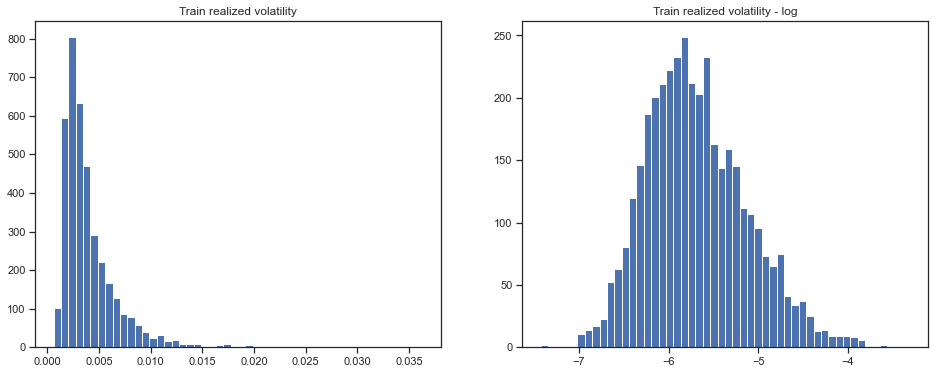

In [23]:
targets_stock0 = targets_train[targets_train['stock_id'] == 0]

sns.set_theme(style="ticks")
fig = plt.figure(figsize=(16, 6))
# fig.suptitle('Images after equalization preprocessing', fontsize=16)
# fig.tight_layout()

plt.subplot(1, 2, 1)
plt.title("Train realized volatility")
plt.hist(targets_stock0['target'], bins=50)


plt.subplot(1, 2, 2)
plt.title("Train realized volatility - log")
plt.hist(np.log(targets_stock0['target']), bins=50)

plt.show()

# kaggle instructions + naive RMSE



In [24]:
# select all stocks books
list_order_book_file_train = glob.glob(data_folder + bk_train_fol + '/*')

In [25]:
def realized_volatility_per_time_id(file_path, prediction_column_name):
    '''load datas of one stock_id then calculate WAP, log_return
    set a new DF and put inside realized_volatility per time_id
    add a column with competition form : {stock_id}-{time_id} called row_id

    file_path : path of subfolders with stock_id
        example : ./data/book_train/stock_id=0
    prediction_column_name : name of the realized_volatility column
    
    return row_id, prediction_name columns'''
    df_book_data = pd.read_parquet(file_path)
    add_wap(df_book_data)

    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap1'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()] # removing each Nan of firsts time_id, ~ : invers the mask

    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [26]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

# test on all 126 stocks 
# long ! 230 sec
# df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
#                                                            prediction_column_name='pred')
# df_past_realized_train.head()

In [ ]:
data_train = targets_train.copy()
# Let's join the output dataframe with train.csv to see the performance of the naive prediction on training set.
# naive prediction = predict same volatility in the next 10min window (auto realisation)
data_train['row_id'] = data_train['stock_id'].astype(str) + '-' + data_train['time_id'].astype(str)
data_train = data_train[['row_id','target']]
df_joined = data_train.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')

In [28]:
df_joined.head()

NameError: name 'df_joined' is not defined

In [ ]:
from sklearn.metrics import r2_score

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [ ]:
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.628, RMSPE: 0.341


# My model

## Improvements

add MAD var, std ?
exponential moving average : pandas.Series.ewm()

instead of dic, more explicit, list to pass to agg  
max_height=pd.NamedAgg(column='height', aggfunc='max'),  
min_weight=pd.NamedAgg(column='weight', aggfunc='min')

fill empty second_in_bucket in book data with the same as the last one
fill                            trade with 0 ?

## Feature engineering

In [29]:
number_of_stocks = 2

### Book

In [30]:
list_order_book_file_train = glob.glob(data_folder + bk_train_fol + '/*')[:number_of_stocks]

In [31]:
def add_ponderate_wap(df, col_name='wap_p'):
        df[col_name] = ((
        df['wap1'] * (df['ask_size1'] + df['bid_size1']) +
        df['wap2'] * (df['ask_size2'] + df['bid_size2'])) /
        (df['ask_size1'] + df['bid_size1'] + df['ask_size2'] + df['bid_size2']))

def add_log_return(df, price_col, log_col_name, group='time_id'):
        df[log_col_name] = df.groupby([group])[price_col].apply(log_return)

# def add_realized_volatility(df, log_col, vol_col_name, group='time_id'):
#         df[vol_col_name] = df.groupby([group])[log_col].agg(realized_volatility)

def add_balance_to_mean(df, price, bal_col_nam, group='time_id'):
        df[bal_col_nam] = book_train[price] - book_train.groupby([group])[price].transform('mean')



In [32]:
def book_feature_eng_per_stock(file_path):
    # '''load datas of one stock_id then calculate WAP, log_return
    # set a new DF and put inside realized_volatility per time_id
    # add a column with competition form : {stock_id}-{time_id} called row_id

    # file_path : path of subfolders with stock_id
    #     example : ./data/book_train/stock_id=0
    # prediction_column_name : name of the realized_volatility column
    
    # return row_id, prediction_name columns'''
    book_train = pd.read_parquet(file_path)

    add_wap(book_train, 1, column_prefix='wap')
    add_wap(book_train, 2, column_prefix='wap')
    add_ponderate_wap(book_train, col_name='wap_p')

    add_log_return(book_train, 'wap1', 'log_return')
    add_log_return(book_train, 'wap_p', 'log_return_p')

    book_train = book_train[~(book_train['log_return'].isnull() | book_train['log_return_p'].isnull())] # at the end ?
    
    stock_id = file_path.split('=')[1]
    
    return book_train, stock_id

In [33]:
# sample with stock 0
book_feature_eng_per_stock(list_order_book_file_train[0])[0].head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap1,wap2,wap_p,log_return,log_return_p
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,1.001448,1.001390,1.001419,0.000014,-1.250457e-06
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,1.001448,1.001391,1.001419,0.000000,5.040343e-07
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443,1.001391,1.001420,-0.000005,3.130015e-07
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443,1.001391,1.001420,0.000000,0.000000e+00
5,5,11,1.001422,1.002301,1.00137,1.002405,3,100,2,100,1.001448,1.001391,1.001419,0.000005,-3.130015e-07


In [34]:
# feature_dict = {
# 'log_return':[realized_volatility],
# 'log_return_p':[realized_volatility],
# 'wap1':[np.mean],
# 'wap2':[np.mean],
# 'wap_p':[np.mean, np.var, pd.Series.mad]
#         }

# feature_agg = (
#         realized_vol_log_return=('log_return', realized_volatility),
#         realized_vol_log_return_p=('log_return_p', realized_volatility),
#         wap1_mean=('wap1', np.mean),
#         wap2_mean=('wap2', np.mean),
#         wap_p_mean=('wap_p', np.mean),
#         wap_p_var=('wap_p', np.var),
#         wap_p_mad=('wap_p', pd.Series.mad),
# )


In [35]:
# def book_aggregate_form(list_file,dic):

#     df_agg = pd.DataFrame()
#     for file in list_file:
#         df_agg_stock, stock_id = book_feature_eng_per_stock(file)
#         df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(dic)).reset_index()

#         df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
        
#         df_agg = pd.concat([df_agg, df_agg_stock])

#     return df_agg

def book_aggregate_form(list_file):

    df_agg = pd.DataFrame()
    for file in list_file:
        df_agg_stock, stock_id = book_feature_eng_per_stock(file)
        df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(
                    realized_vol_log_return=('log_return', realized_volatility),
                    realized_vol_log_return_p=('log_return_p', realized_volatility),
                    wap1_mean=('wap1', np.mean),
                    wap2_mean=('wap2', np.mean),
                    wap_p_mean=('wap_p', np.mean),
                    wap_p_var=('wap_p', np.var),
                    wap_p_mad=('wap_p', pd.Series.mad),
                    )).reset_index()
        df_agg_stock['stock_id'] = stock_id

        df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
        
        df_agg = pd.concat([df_agg, df_agg_stock])

    return df_agg

In [36]:
%%time
# df_book_agg = book_aggregate_form(list_order_book_file_train, feature_dict)
df_book_agg = book_aggregate_form(list_order_book_file_train)

df_book_agg.head()

Wall time: 11.4 s


,time_id,realized_vol_log_return,realized_vol_log_return_p,wap1_mean,wap2_mean,wap_p_mean,wap_p_var,wap_p_mad,stock_id,row_id
0,5,0.004499,0.004106,1.003733,1.003668,1.003735,4.938360e-07,0.000472,0,0-5
1,11,0.001204,0.001507,1.000240,1.000208,1.000238,5.125136e-08,0.000171,0,0-11
2,16,0.002369,0.002469,0.999541,0.999682,0.999603,7.228531e-07,0.000674,0,0-16
3,31,0.002574,0.002709,0.998819,0.998624,0.998732,4.741041e-07,0.000520,0,0-31
4,62,0.001894,0.001932,0.999616,0.999624,0.999654,6.201692e-08,0.000210,0,0-62


### Trades

### Joining

In [37]:
targets_train.stock_id.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  46,  47,  48,  50,  51,  52,  53,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  72,  73,
        74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 120, 122, 123, 124, 125, 126], dtype=int64)

In [38]:
targets_train['row_id'] = targets_train['stock_id'].astype(str) + '-' + targets_train['time_id'].astype(str)
targets_train = targets_train[['row_id','target']]
df_joined = df_book_agg.merge(targets_train, on = ['row_id'], how = 'left')
# df_joined.drop(columns='time_id', inplace=True)
df_joined.head()

,time_id,realized_vol_log_return,realized_vol_log_return_p,wap1_mean,wap2_mean,wap_p_mean,wap_p_var,wap_p_mad,stock_id,row_id,target
0,5,0.004499,0.004106,1.003733,1.003668,1.003735,4.938360e-07,0.000472,0,0-5,0.004136
1,11,0.001204,0.001507,1.000240,1.000208,1.000238,5.125136e-08,0.000171,0,0-11,0.001445
2,16,0.002369,0.002469,0.999541,0.999682,0.999603,7.228531e-07,0.000674,0,0-16,0.002168
3,31,0.002574,0.002709,0.998819,0.998624,0.998732,4.741041e-07,0.000520,0,0-31,0.002195
4,62,0.001894,0.001932,0.999616,0.999624,0.999654,6.201692e-08,0.000210,0,0-62,0.001747


''

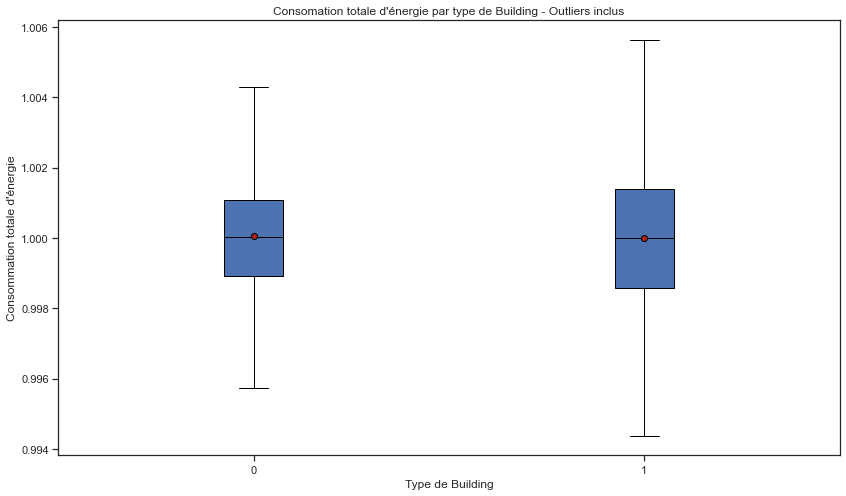

In [44]:
#Création d'un sous échantillon par modalité
groupes = []
for s in df_joined['stock_id'].unique():
    groupes.append(df_joined[df_joined['stock_id'] == s]['wap_p_mean'])
 
# 'OO' méthode pour plot
fig, ax = plt.subplots(figsize=(14,8))

# Propriétés graphiques
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

ax.boxplot(groupes,
           labels=df_joined['stock_id'].unique(),
           showfliers=False,
           medianprops=medianprops, 
           vert=True,
           patch_artist=True,
           showmeans=True,
           meanprops=meanprops)

ax.set(title='Distribution des wap_p par stock',
      xlabel="Stock Id",
      ylabel='wap_p')
;

## machine learning

In [39]:
df_joined.head()

,time_id,realized_vol_log_return,realized_vol_log_return_p,wap1_mean,wap2_mean,wap_p_mean,wap_p_var,wap_p_mad,stock_id,row_id,target
0,5,0.004499,0.004106,1.003733,1.003668,1.003735,4.938360e-07,0.000472,0,0-5,0.004136
1,11,0.001204,0.001507,1.000240,1.000208,1.000238,5.125136e-08,0.000171,0,0-11,0.001445
2,16,0.002369,0.002469,0.999541,0.999682,0.999603,7.228531e-07,0.000674,0,0-16,0.002168
3,31,0.002574,0.002709,0.998819,0.998624,0.998732,4.741041e-07,0.000520,0,0-31,0.002195
4,62,0.001894,0.001932,0.999616,0.999624,0.999654,6.201692e-08,0.000210,0,0-62,0.001747


In [40]:
df_joined.isnull().sum()

# fill_na

time_id                      0
realized_vol_log_return      0
realized_vol_log_return_p    0
wap1_mean                    0
wap2_mean                    0
wap_p_mean                   0
wap_p_var                    0
wap_p_mad                    0
stock_id                     0
row_id                       0
target                       0
dtype: int64

# Submission

In [41]:
# list_order_book_file_test = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_test.parquet/*')

# df_naive_pred_test = past_realized_volatility_per_stock(list_file=list_order_book_file_test,
#                                                            prediction_column_name='target')
# df_naive_pred_test.to_csv('submission.csv',index = False)